In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.model_selection import train_test_split

import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout


#show wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

#suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-reviews/winemag-data_first150k.csv
/kaggle/input/wine-reviews/winemag-data-130k-v2.json
/kaggle/input/wine-reviews/winemag-data-130k-v2.csv


In [26]:
df = pd.read_csv('../input/wine-reviews/winemag-data_first150k.csv')

In [27]:
df.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez


In [28]:
df['variety'].nunique()

632

### There are some 632 varieties of wine in the dataframe. Let's select the top 5 varieties and build a model to correctly classify them using the description column.

In [29]:
df_train = df[['description', 'variety']]

In [30]:
#we will take only the top 5 varieties
top_varieties = df_train['variety'].value_counts().head(5).index
df_top_5 = df_train[df_train['variety'].isin(top_varieties)]
df_top_5.shape

(58982, 2)

In [31]:
df_top_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58982 entries, 0 to 150912
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  58982 non-null  object
 1   variety      58982 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [32]:
#preprocessing
def preprocess_text(df):
    #remove special characters
    df['description'] = df['description'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    #convert to lowercase
    df['description'] = df['description'].apply(lambda x: x.lower())
    #remove stopwords
    stop_words = stopwords.words('english')
    df['description'] = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    df['description'] = df['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    #encode the labels
    df['variety'] = df['variety'].factorize()[0]
    return df

In [33]:
df_train_test_processed = preprocess_text(df_top_5)

In [34]:
df_train_test_processed.head()

,description,variety
0,tremendous varietal wine hail oakville aged th...,0
3,spent month new french oak incorporates fruit ...,1
8,named vineyard formerly bottled delancellotti ...,1
9,producer source two block vineyard wine one hi...,1
11,year old vine supple well balanced effort blen...,1


### Show the wordcloud to see most used words

In [44]:
#show wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords.words('english'),
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

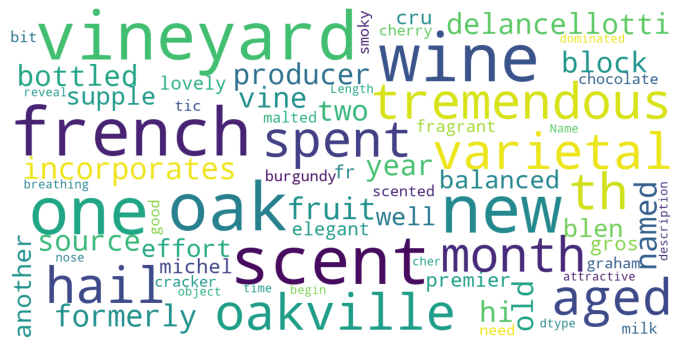

In [45]:
#show wordcloud
show_wordcloud(df_train_test_processed['description'])

In [35]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_train_test_processed['description'], df_train_test_processed['variety'], test_size=0.2, random_state=42)

In [36]:
#check how many unique words we have
vocab_size = len(set(' '.join(X_train).split()))
print('Vocab size: ', vocab_size)

Vocab size:  16557


In [37]:
#vocab size
vocab_size = 10000
encoded_docs_train = [one_hot(d, vocab_size) for d in X_train]
encoded_docs_test = [one_hot(d, vocab_size) for d in X_test]

In [38]:
#pad the sequences
max_length = 100
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

In [39]:
#max length
max_length = 100
#embedding size
embedding_size = 32
#number of classes
num_classes = 5
#model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_length))
#bidirectional LSTM
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 336,965
Trainable params: 336,965
Non-trainable params: 0
_________________________________________________________________


In [40]:
#train the model
model.fit(padded_docs_train, y_train, epochs=10, verbose=1)

Epoch 1/10
1475/1475 [==============================] - 17s 10ms/step - loss: 0.5980 - accuracy: 0.7780
Epoch 2/10
1475/1475 [==============================] - 14s 10ms/step - loss: 0.3108 - accuracy: 0.8952
Epoch 3/10
1475/1475 [==============================] - 14s 10ms/step - loss: 0.2452 - accuracy: 0.9188
Epoch 4/10
1475/1475 [==============================] - 14s 10ms/step - loss: 0.2042 - accuracy: 0.9334
Epoch 5/10
1475/1475 [==============================] - 14s 9ms/step - loss: 0.1743 - accuracy: 0.9434
Epoch 6/10
1475/1475 [==============================] - 15s 10ms/step - loss: 0.1502 - accuracy: 0.9515
Epoch 7/10
1475/1475 [==============================] - 14s 9ms/step - loss: 0.1283 - accuracy: 0.9601
Epoch 8/10
1475/1475 [==============================] - 14s 10ms/step - loss: 0.1153 - accuracy: 0.9639
Epoch 9/10
1475/1475 [==============================] - 14s 10ms/step - loss: 0.1018 - accuracy: 0.9682
Epoch 10/10
1475/1475 [==============================] - 14s 10ms/

In [41]:
#evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

369/369 [==============================] - 3s 5ms/step - loss: 0.4214 - accuracy: 0.9036
Accuracy: 90.361959
